# Pose Linear Metrics Statistical Analysis

This notebook performs comprehensive statistical analysis on all pose linear metrics using mixed-effects models and generates publication-ready figures.

## Important
Before using this notebook:
1. Download the raw pose data
2. Run `process_pose_data.py`

## Setup and Imports

To start, let's import relevant libraries and set the metrics for analysis:

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('..')  # Add parent directory
from stats_utils.stats_figures import run_rpy2_lmer, barplot_ax
import matplotlib.pyplot as plt
from Pose.utils.io_utils import load_participant_info_file

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


## Load Data

Load and optionally combine data across different methods (original vs. procrustes aligned data):

In [2]:
# Get processed data for further analysis
data_dir = Path("data") / "processed" / "linear_metrics"
methods_to_load = ["original", "procrustes_global", "procrustes_participant"]

# Load and concatenate all pose linear metrics files
pose_dfs = []
for method in methods_to_load:
    file_path = data_dir / f"{method}_linear.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        df["method"] = method
        pose_dfs.append(df)
        print(f"Loaded {method}: {df.shape[0]} rows")
    else:
        print(f"Warning: {file_path.name} not found")

if not pose_dfs:
    raise FileNotFoundError("No pose linear metrics files found.")

pose_metrics_df = pd.concat(pose_dfs, ignore_index=True)
print(f"Combined DataFrame shape: {pose_metrics_df.shape}")

Loaded original: 2021 rows
Loaded procrustes_global: 2021 rows
Loaded procrustes_participant: 2021 rows
Combined DataFrame shape: (6063, 385)


## Select Metrics for Analysis

In [3]:
# Option 1: Analyze ALL metrics (overrides other options if True)
ANALYZE_ALL_METRICS = False

# Option 2: Analyze specific metrics by name
SELECTED_METRICS = [
    # --- Head rotation metrics ---
    "head_rotation_rad_rms",
    "head_rotation_rad_vel_mean",
    "head_rotation_rad_mean",

    # --- Blink metrics ---
    "blink_aperture_mean",
    "blink_aperture_rms",
    
    # --- Mouth metrics ---
    "mouth_aperture_mean",
    "mouth_aperture_rms",

    # --- Pupil metrics ---
    "pupil_dx_rms",
    "pupil_dy_rms",
    "pupil_metric_rms",

    # --- Center face metrics ---
    "center_face_magnitude_rms",
    "center_face_x_rms",
    "center_face_y_rms",
]

In [4]:
# Load session information
participant_info_path = load_participant_info_file()
Session_Info = pd.read_csv(participant_info_path)

# Add session_order string
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )

session_order_numeric_map = {"LMH": 1, "LHM": 2}

# === Derive condition from participant_info ===
def get_condition(row):
    pid = int(row['participant'])
    # If session_number is already present, map directly
    if "session_number" in row and not pd.isna(row["session_number"]):
        session_col = f"session{int(row['session_number']):02d}"
        if session_col in Session_Info.columns:
            cond = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond) > 0:
                return cond[0]
    # Otherwise try matching to session01–03
    for s_num in [1, 2, 3]:
        session_col = f"session{s_num:02d}"
        if session_col in Session_Info.columns:
            cond_val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond_val) > 0:
                # If this condition matches the pose row's 'condition' (if present), use this session
                if "condition" in row and str(row["condition"]).strip().upper() == str(cond_val[0]).strip().upper():
                    return cond_val[0]
    return None

# === Derive session_number by reverse lookup ===
def get_session_number(row):
    pid = int(row['participant'])
    row_cond = str(row.get('condition', '')).strip().upper()
    if row_cond in {"L", "M", "H"}:
        for s_num in [1, 2, 3]:
            session_col = f"session{s_num:02d}"
            if session_col in Session_Info.columns:
                val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
                if len(val) > 0 and str(val[0]).strip().upper() == row_cond:
                    return s_num
    return np.nan

# Apply mapping
pose_metrics_df["condition"] = pose_metrics_df.apply(get_condition, axis=1)
pose_metrics_df["condition"] = pose_metrics_df["condition"].astype(str).str.strip().str.upper()
pose_metrics_df["session_number"] = pose_metrics_df.apply(get_session_number, axis=1)

# === Map session_order_numeric ===
if "session_order" in Session_Info.columns:
    session_info_numeric_map = Session_Info.set_index("Participant ID")["session_order"].map(session_order_numeric_map).to_dict()
    pose_metrics_df["session_order_numeric"] = pose_metrics_df["participant"].astype(int).map(session_info_numeric_map)

# Select metrics
metadata_cols = {
    "source", "participant", "condition", "window_index",
    "t_start_frame", "t_end_frame", "session_order", "session_order_numeric",
    "session_number", "method"
}

all_metric_cols = [c for c in pose_metrics_df.columns if c not in metadata_cols]

if ANALYZE_ALL_METRICS:
    # Use all metrics
    metric_cols = all_metric_cols

elif SELECTED_METRICS:
    # Use only explicitly listed metrics, warn for missing
    metric_cols = [col for col in SELECTED_METRICS if col in all_metric_cols]
    missing = [col for col in SELECTED_METRICS if col not in all_metric_cols]
    if missing:
        print(f"⚠️ Warning: {len(missing)} selected metrics not found:\n  - " + "\n  - ".join(missing))

else:
    raise ValueError("No metric selection mode specified. Enable one of: "
                     "ANALYZE_ALL_METRICS, SELECTED_METRICS, or METRIC_PATTERNS")

print(f"\n✅ Selected {len(metric_cols)} metrics for analysis:")
for m in metric_cols:
    print(f"  - {m}")


✅ Selected 13 metrics for analysis:
  - head_rotation_rad_rms
  - head_rotation_rad_vel_mean
  - head_rotation_rad_mean
  - blink_aperture_mean
  - blink_aperture_rms
  - mouth_aperture_mean
  - mouth_aperture_rms
  - pupil_dx_rms
  - pupil_dy_rms
  - pupil_metric_rms
  - center_face_magnitude_rms
  - center_face_x_rms
  - center_face_y_rms


C:\Users\mq20191720\AppData\Local\Temp\ipykernel_33416\4236667616.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pose_metrics_df["session_number"] = pose_metrics_df.apply(get_session_number, axis=1)
C:\Users\mq20191720\AppData\Local\Temp\ipykernel_33416\4236667616.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pose_metrics_df["session_order_numeric"] = pose_metrics_df["participant"].astype(int).map(session_info_numeric_map)


## Run Statistic Analyses and Plots

Run stats and make plots for the metrics of interest:

R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  



Analyzing original normalization method...
Means for head_rotation_rad_rms:
  H: 0.098
  L: 0.095
  M: 0.106


R callback write-console: 
Attaching package: 'lmerTest'

  
R callback write-console: The following object is masked from 'package:lme4':

    lmer

  
R callback write-console: The following object is masked from 'package:stats':

    step

  
R callback write-console: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
  



=== original_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -7612.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3304 -0.4140 -0.0524  0.3585 13.1246 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.003112 0.05579 
 Residual                   0.001166 0.03415 
Number of obs: 2011, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.576e-02  2.702e-02  4.318e+01   2.064   0.0451 *  
condition.L            1.983e-03  1.321e-03  1.963e+03   1.502   0.1333    
condition.Q           -7.693e-03  1.318e-03  1.963e+03  -5.838 6.16e-09 ***
session_order_numeric  2.494e-02  1.674e-02  4.301e+01   1.490   0.1436    
window_index  

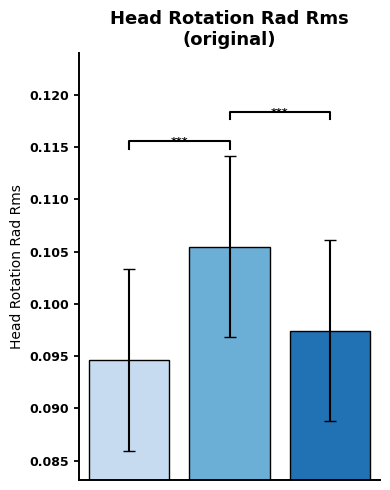

R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_rotation_rad_vel_mean:
  H: -0.000
  L: -0.000
  M: -0.000

=== original_head_rotation_rad_vel_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -18958.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.2192  -0.3469   0.0165   0.3751  12.6301 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.000e+00 0.000000
 Residual                   4.519e-06 0.002126
Number of obs: 2011, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)
(Intercept)            2.685e-05  1.712e-04  2.006e+03   0.157    0.875
condition.L           -2.161e-05  8.219e-05  2.006e+03  -0.263    0.793
condition.Q           -4.372e-05  8.203e-05  2.006e+03  -0.533    0.594
session_order

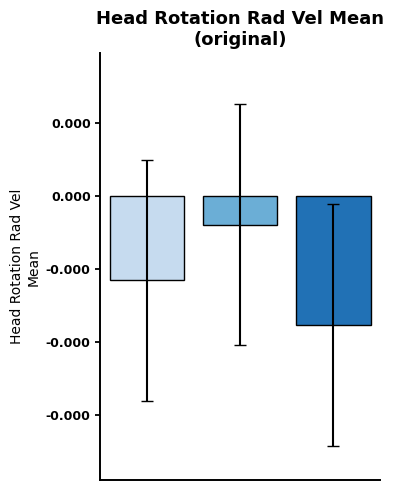

Means for head_rotation_rad_mean:
  H: -0.015
  L: -0.019
  M: -0.016

=== original_head_rotation_rad_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -7615.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.8107 -0.5191 -0.0145  0.4766  6.4763 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.006721 0.08198 
 Residual                   0.001145 0.03384 
Number of obs: 2011, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)            1.994e-02  3.959e-02  4.308e+01   0.504  0.61713   
condition.L            3.474e-03  1.308e-03  1.963e+03   2.655  0.00799 **
condition.Q           -1.584e-04  1.306e-03  1.963e+03  -0.121  0.90342   
session_order_numeric -

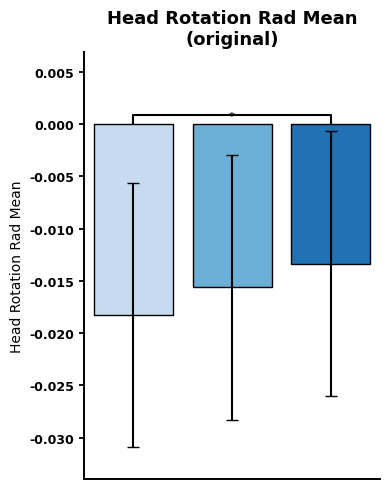

Means for blink_aperture_mean:
  H: 0.140
  L: 0.142
  M: 0.142

=== original_blink_aperture_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -14459

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2331 -0.6347 -0.0310  0.6104  3.6557 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 3.862e-04 0.019651
 Residual                   3.831e-05 0.006189
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.363e-01  9.481e-03  4.305e+01  14.376  < 2e-16 ***
condition.L           -1.785e-03  2.389e-04  1.970e+03  -7.470 1.19e-13 ***
condition.Q           -3.483e-04  2.384e-04  1.970e+03  -1.461    0.144    
session_order_numeric  2.6

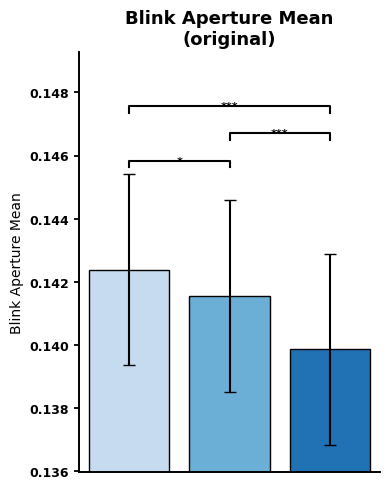

Means for blink_aperture_rms:
  H: 0.147
  L: 0.148
  M: 0.148

=== original_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -15000.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5688 -0.6218 -0.0420  0.5786  3.6340 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 4.203e-04 0.02050 
 Residual                   2.905e-05 0.00539 
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.427e-01  9.887e-03  4.303e+01  14.438  < 2e-16 ***
condition.L           -1.182e-03  2.080e-04  1.970e+03  -5.681 1.54e-08 ***
condition.Q           -3.394e-04  2.077e-04  1.970e+03  -1.635 0.102258    
session_order_numeric  2.7

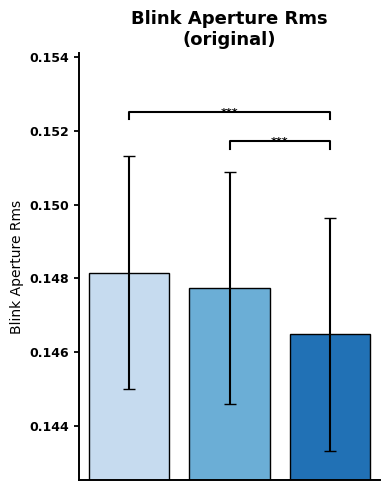

Means for mouth_aperture_mean:
  H: 0.011
  L: 0.010
  M: 0.008

=== original_mouth_aperture_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -13181.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8077 -0.2457 -0.0696  0.1488  8.8791 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 8.857e-05 0.009411
 Residual                   7.462e-05 0.008638
Number of obs: 2014, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.708e-02  4.588e-03  4.341e+01   3.723 0.000563 ***
condition.L            6.930e-04  3.338e-04  1.966e+03   2.076 0.038022 *  
condition.Q            1.865e-03  3.331e-04  1.966e+03   5.599 2.45e-08 ***
session_order_numeric -4

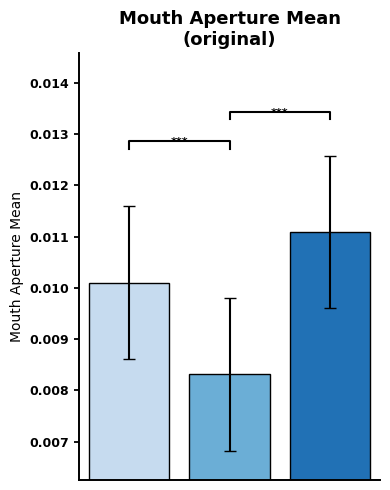

Means for mouth_aperture_rms:
  H: 0.016
  L: 0.015
  M: 0.012

=== original_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -12131

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4288 -0.2945 -0.0755  0.1566  7.9767 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001708 0.01307 
 Residual                   0.0001255 0.01120 
Number of obs: 2014, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.274e-02  6.361e-03  4.335e+01   3.575 0.000876 ***
condition.L            1.297e-03  4.329e-04  1.966e+03   2.996 0.002773 ** 
condition.Q            2.594e-03  4.320e-04  1.966e+03   6.006 2.26e-09 ***
session_order_numeric -5.083

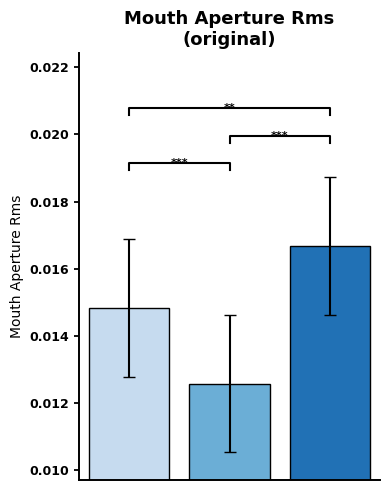

Means for pupil_dx_rms:
  H: 0.006
  L: 0.006
  M: 0.005

=== original_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -16922.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6222 -0.1707 -0.0268  0.1078 28.2319 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.806e-06 0.001675
 Residual                   1.224e-05 0.003499
Number of obs: 2019, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.403e-03  8.547e-04  4.474e+01   6.322 1.06e-07 ***
condition.L            2.475e-04  1.350e-04  1.971e+03   1.834  0.06684 .  
condition.Q            3.922e-04  1.348e-04  1.971e+03   2.910  0.00365 ** 
session_order_numeric  2.642e-04  5.24

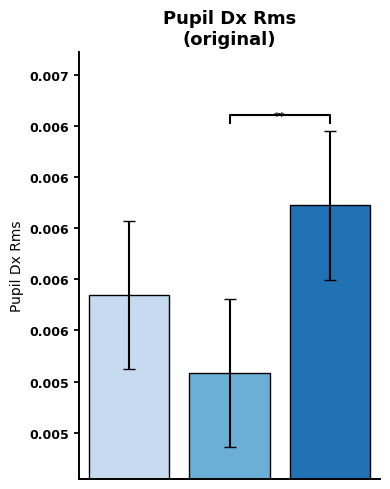

Means for pupil_dy_rms:
  H: 0.024
  L: 0.023
  M: 0.022

=== original_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -11989.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0643 -0.1351 -0.0197  0.0983 28.8503 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.816e-05 0.005307
 Residual                   1.422e-04 0.011924
Number of obs: 2019, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.221e-02  2.731e-03  4.503e+01   8.133  2.2e-10 ***
condition.L            6.327e-04  4.600e-04  1.971e+03   1.375   0.1692    
condition.Q            1.004e-03  4.593e-04  1.971e+03   2.187   0.0289 *  
session_order_numeric  9.494e-04  1.67

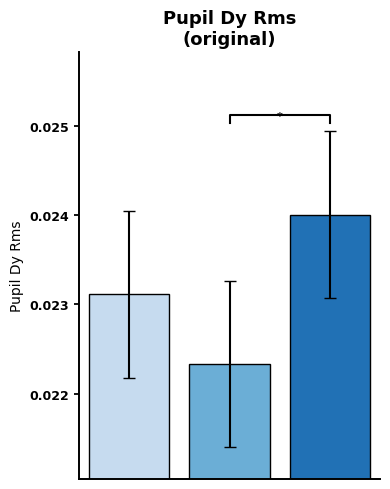

Means for pupil_metric_rms:
  H: 0.043
  L: 0.042
  M: 0.042

=== original_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -11941.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9041 -0.1173 -0.0166  0.0786 29.4283 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.73e-05 0.004159
 Residual                   1.47e-04 0.012126
Number of obs: 2019, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.078e-02  2.228e-03  4.616e+01  18.301   <2e-16 ***
condition.L            7.624e-04  4.678e-04  1.971e+03   1.630   0.1033    
condition.Q            8.984e-04  4.671e-04  1.971e+03   1.923   0.0546 .  
session_order_numeric  1.368e-03 

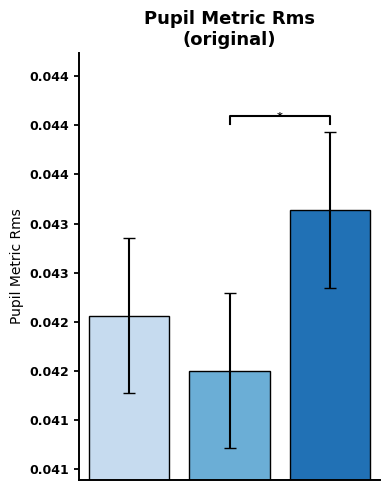

Means for center_face_magnitude_rms:
  H: 0.245
  L: 0.222
  M: 0.224

=== original_center_face_magnitude_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -5067.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6666 -0.5449 -0.1023  0.4204 11.6600 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.005577 0.07468 
 Residual                   0.004242 0.06513 
Number of obs: 2017, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.646e-01  3.636e-02  4.332e+01   4.526 4.64e-05 ***
condition.L            1.477e-02  2.515e-03  1.969e+03   5.872 5.06e-09 ***
condition.Q            8.670e-03  2.510e-03  1.969e+03   3.455 0.000562 ***
session_order_nu

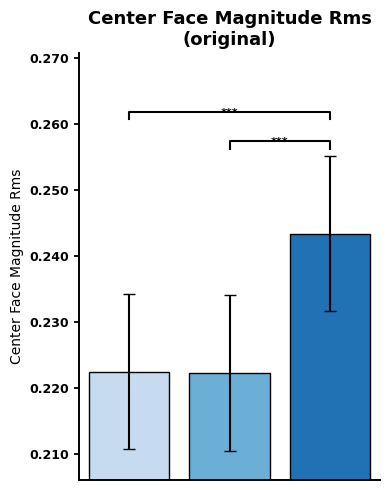

Means for center_face_x_rms:
  H: 0.158
  L: 0.136
  M: 0.150

=== original_center_face_x_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -6421.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1683 -0.6242 -0.0863  0.4587  6.5336 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.002480 0.04980 
 Residual                   0.002171 0.04659 
Number of obs: 2017, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            9.209e-02  2.429e-02  4.340e+01   3.792 0.000458 ***
condition.L            1.500e-02  1.799e-03  1.969e+03   8.335  < 2e-16 ***
condition.Q           -1.918e-03  1.795e-03  1.969e+03  -1.068 0.285542    
session_order_numeric  3.520e-02

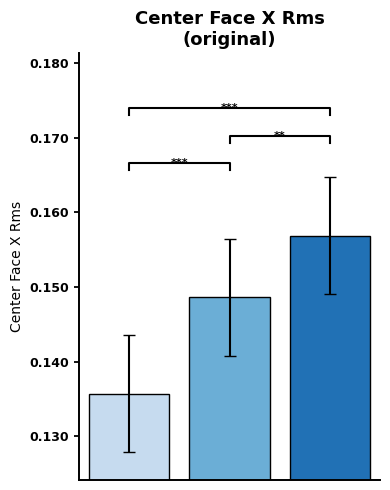

Means for center_face_y_rms:
  H: 0.180
  L: 0.171
  M: 0.161

=== original_center_face_y_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -5606.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3675 -0.5575 -0.0868  0.3686 12.3379 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.003934 0.06272 
 Residual                   0.003252 0.05702 
Number of obs: 2017, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.338e-01  3.057e-02  4.334e+01   4.376 7.48e-05 ***
condition.L            5.562e-03  2.202e-03  1.969e+03   2.526   0.0116 *  
condition.Q            1.253e-02  2.197e-03  1.969e+03   5.701 1.37e-08 ***
session_order_numeric  2.710e-02

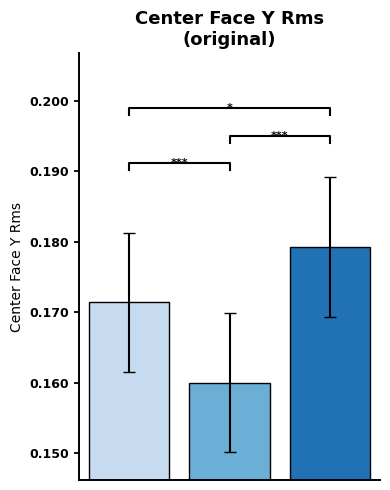


Analyzing procrustes_global normalization method...
Means for head_rotation_rad_rms:
  H: 0.064
  L: 0.061
  M: 0.068

=== procrustes_global_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9063.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.2293 -0.3943 -0.0596  0.3328 14.4781 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0012191 0.03492 
 Residual                   0.0005819 0.02412 
Number of obs: 2021, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.690e-02  1.693e-02  4.323e+01   2.179  0.03484 *  
condition.L            1.788e-03  9.300e-04  1.973e+03   1.922  0.05473 .  
condition.Q           -4.933e-03  9

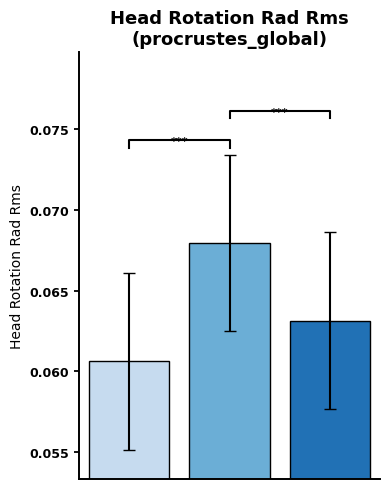

R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_rotation_rad_vel_mean:
  H: -0.000
  L: -0.000
  M: -0.000

=== procrustes_global_head_rotation_rad_vel_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -20656

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.9722 -0.3150  0.0138  0.3371 12.9704 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.00e+00 0.000000
 Residual                   2.04e-06 0.001428
Number of obs: 2021, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)
(Intercept)            3.757e-05  1.148e-04  2.016e+03   0.327    0.744
condition.L           -1.008e-05  5.506e-05  2.016e+03  -0.183    0.855
condition.Q           -3.322e-05  5.501e-05  2.016e+03  -0.604    0.546
session_order_numer

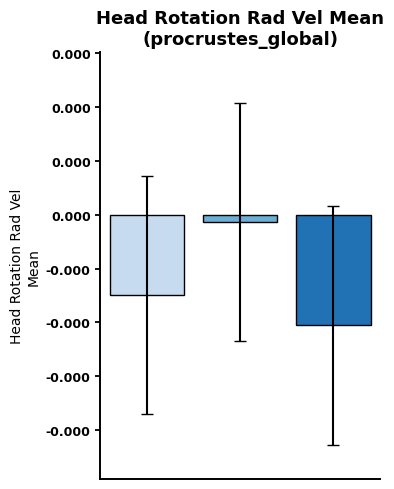

Means for head_rotation_rad_mean:
  H: 0.002
  L: -0.002
  M: 0.001

=== procrustes_global_head_rotation_rad_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9248.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.7350 -0.5093 -0.0111  0.4668  6.8557 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.002603 0.05102 
 Residual                   0.000521 0.02283 
Number of obs: 2021, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.481e-02  2.465e-02  4.310e+01   1.007 0.319727    
condition.L            3.044e-03  8.800e-04  1.973e+03   3.459 0.000554 ***
condition.Q           -2.912e-04  8.790e-04  1.973e+03  -0.331 0.740512    
session_orde

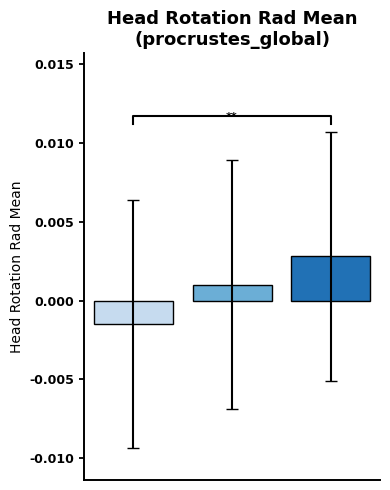

Means for blink_aperture_mean:
  H: 0.140
  L: 0.143
  M: 0.143

=== procrustes_global_blink_aperture_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -13790.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0669 -0.6592 -0.0023  0.6241  3.8801 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 5.970e-04 0.024433
 Residual                   5.328e-05 0.007299
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.360e-01  1.179e-02  4.304e+01  11.537 9.34e-15 ***
condition.L           -2.132e-03  2.817e-04  1.970e+03  -7.567 5.82e-14 ***
condition.Q           -7.121e-04  2.812e-04  1.970e+03  -2.532   0.0114 *  
session_order_n

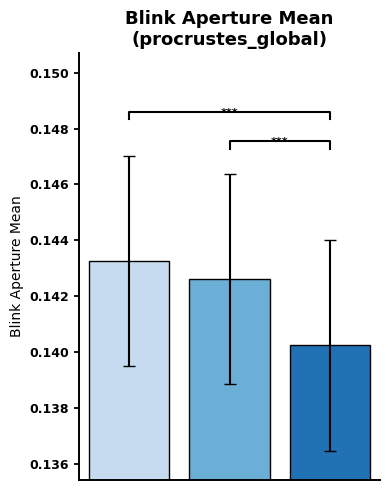

Means for blink_aperture_rms:
  H: 0.147
  L: 0.149
  M: 0.149

=== procrustes_global_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -14115

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9471 -0.6517 -0.0062  0.6161  3.9757 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 6.574e-04 0.025639
 Residual                   4.509e-05 0.006715
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.421e-01  1.236e-02  4.303e+01  11.490 1.07e-14 ***
condition.L           -1.578e-03  2.592e-04  1.970e+03  -6.089 1.37e-09 ***
condition.Q           -7.134e-04  2.587e-04  1.970e+03  -2.758  0.00588 ** 
session_order_numer

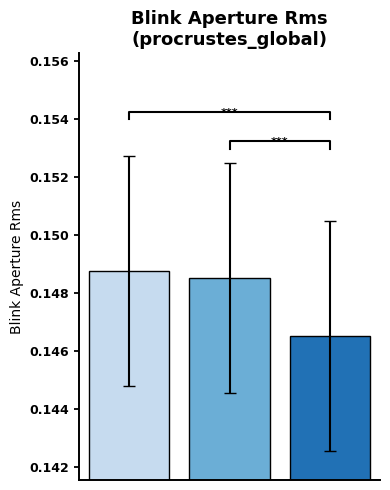

Means for mouth_aperture_mean:
  H: 0.011
  L: 0.010
  M: 0.008

=== procrustes_global_mouth_aperture_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -13409.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1945 -0.2596 -0.0673  0.1421 10.5617 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 7.030e-05 0.008384
 Residual                   6.678e-05 0.008172
Number of obs: 2014, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.602e-02  4.093e-03  4.346e+01   3.913 0.000316 ***
condition.L            8.385e-04  3.158e-04  1.966e+03   2.655 0.007988 ** 
condition.Q            1.788e-03  3.151e-04  1.966e+03   5.673 1.61e-08 ***
session_order_n

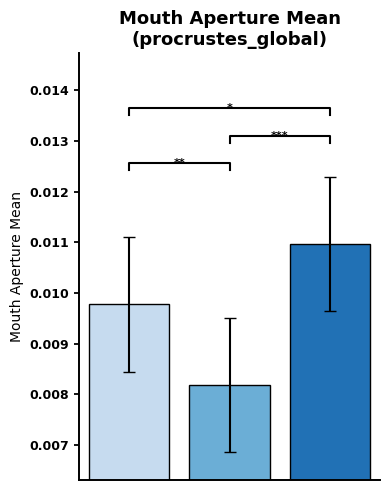

Means for mouth_aperture_rms:
  H: 0.016
  L: 0.014
  M: 0.012

=== procrustes_global_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -12255.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7507 -0.3027 -0.0720  0.1596  8.5426 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001490 0.01221 
 Residual                   0.0001182 0.01087 
Number of obs: 2014, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.153e-02  5.946e-03  4.338e+01   3.620 0.000765 ***
condition.L            1.492e-03  4.201e-04  1.966e+03   3.552 0.000392 ***
condition.Q            2.522e-03  4.192e-04  1.966e+03   6.016 2.13e-09 ***
session_order_num

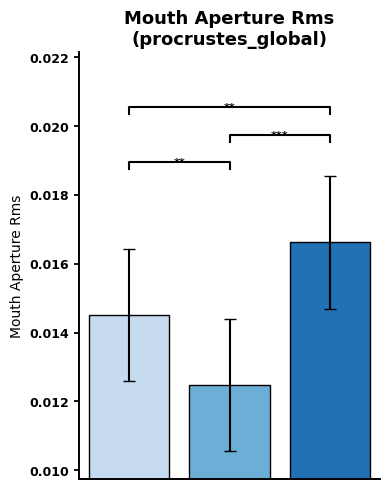

Means for pupil_dx_rms:
  H: 0.008
  L: 0.006
  M: 0.006

=== procrustes_global_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -11890.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0460 -0.0899 -0.0060  0.0532 28.5525 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.746e-05 0.004179
 Residual                   1.504e-04 0.012264
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)            4.874e-03  2.242e-03  4.596e+01   2.174   0.0349 *
condition.L            1.100e-03  4.733e-04  1.970e+03   2.323   0.0203 *
condition.Q            8.579e-04  4.725e-04  1.970e+03   1.816   0.0695 .
session_order_numeric  1.242e-03  1.3

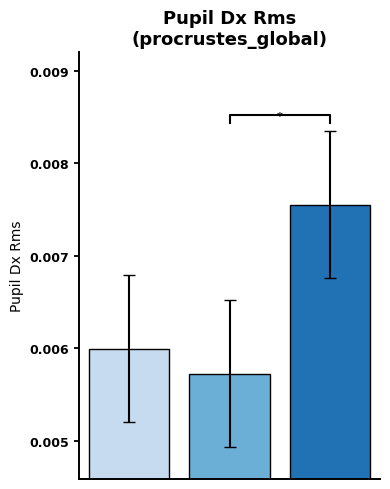

Means for pupil_dy_rms:
  H: 0.024
  L: 0.023
  M: 0.022

=== procrustes_global_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -12115.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2725 -0.1477 -0.0237  0.1077 27.2421 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 4.022e-05 0.006342
 Residual                   1.320e-04 0.011491
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.172e-02  3.192e-03  4.437e+01   6.805 2.12e-08 ***
condition.L            6.618e-04  4.435e-04  1.970e+03   1.492   0.1359    
condition.Q            9.980e-04  4.427e-04  1.970e+03   2.254   0.0243 *  
session_order_numeric  1.131e

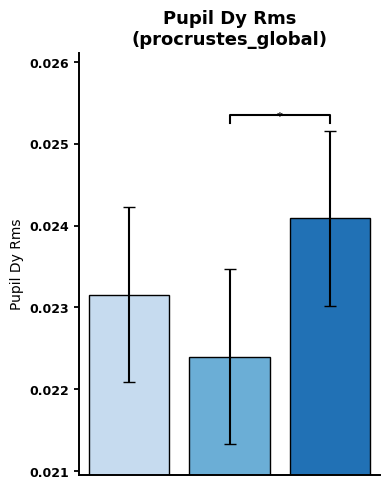

Means for pupil_metric_rms:
  H: 0.044
  L: 0.042
  M: 0.042

=== procrustes_global_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -10700.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1628 -0.1090 -0.0172  0.0847 28.2643 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 4.989e-05 0.007063
 Residual                   2.692e-04 0.016409
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.076e-02  3.650e-03  4.513e+01  11.167 1.41e-14 ***
condition.L            1.177e-03  6.333e-04  1.970e+03   1.859   0.0631 .  
condition.Q            1.134e-03  6.322e-04  1.970e+03   1.794   0.0729 .  
session_order_numeric

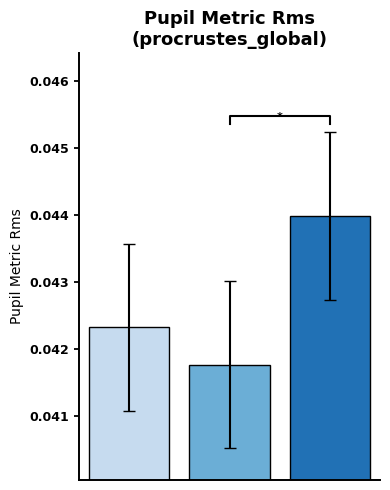


Analyzing procrustes_participant normalization method...
Means for head_rotation_rad_rms:
  H: 0.046
  L: 0.041
  M: 0.048

=== procrustes_participant_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9345.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5119 -0.3517 -0.0735  0.2550 15.5186 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0008425 0.02903 
 Residual                   0.0005083 0.02254 
Number of obs: 2021, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.851e-02  1.410e-02  4.329e+01   1.312   0.1963    
condition.L            3.715e-03  8.692e-04  1.973e+03   4.274 2.01e-05 ***
condition.Q           -4.

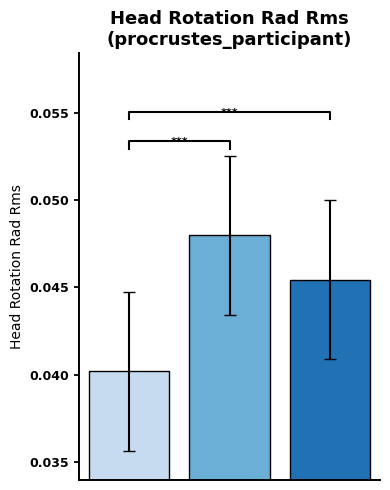

R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_rotation_rad_vel_mean:
  H: -0.000
  L: -0.000
  M: -0.000

=== procrustes_participant_head_rotation_rad_vel_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -20666.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.9983 -0.3120  0.0119  0.3385 13.0084 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.000e+00 0.000000
 Residual                   2.029e-06 0.001425
Number of obs: 2021, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)
(Intercept)            3.836e-05  1.145e-04  2.016e+03   0.335    0.738
condition.L           -1.050e-05  5.491e-05  2.016e+03  -0.191    0.848
condition.Q           -3.277e-05  5.486e-05  2.016e+03  -0.597    0.550
session_o

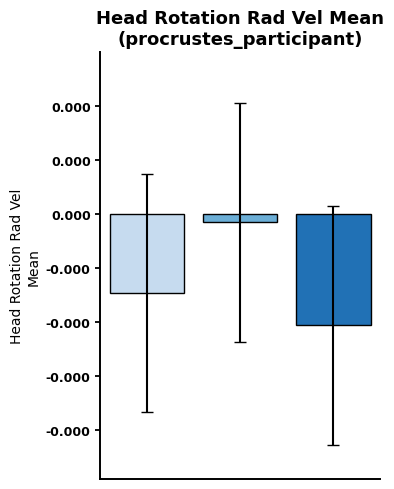

R callback write-console: boundary (singular) fit: see help('isSingular')
  


Means for head_rotation_rad_mean:
  H: 0.002
  L: -0.003
  M: -0.000

=== procrustes_participant_head_rotation_rad_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9525

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.6281 -0.5096 -0.0162  0.4734  7.1680 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.00000  0.00000 
 Residual                   0.00051  0.02258 
Number of obs: 2021, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.533e-03  1.815e-03  2.016e+03   1.396 0.162967    
condition.L            3.047e-03  8.705e-04  2.016e+03   3.500 0.000476 ***
condition.Q           -2.737e-04  8.697e-04  2.016e+03  -0.315 0.753019    
session_

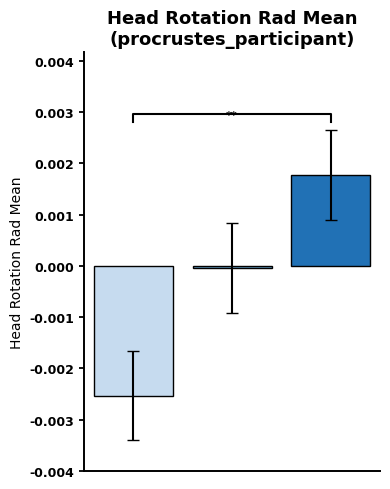

Means for blink_aperture_mean:
  H: 0.139
  L: 0.142
  M: 0.141

=== procrustes_participant_blink_aperture_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -13847.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2592 -0.6808 -0.0050  0.6550  3.9622 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 3.809e-04 0.01952 
 Residual                   5.227e-05 0.00723 
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.348e-01  9.422e-03  4.307e+01  14.304  < 2e-16 ***
condition.L           -2.157e-03  2.791e-04  1.970e+03  -7.728 1.73e-14 ***
condition.Q           -8.232e-04  2.785e-04  1.970e+03  -2.956  0.00316 ** 
session_or

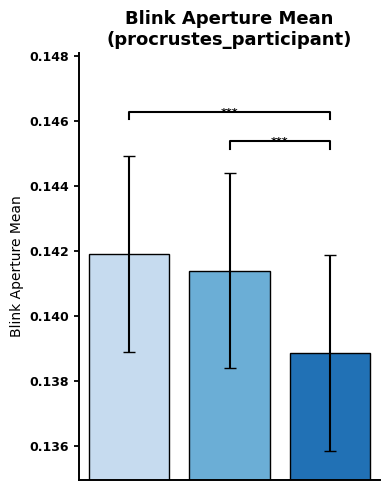

Means for blink_aperture_rms:
  H: 0.145
  L: 0.147
  M: 0.147

=== procrustes_participant_blink_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -14171.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1251 -0.6697  0.0022  0.6326  3.8631 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 4.088e-04 0.020220
 Residual                   4.426e-05 0.006653
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.408e-01  9.757e-03  4.305e+01  14.429  < 2e-16 ***
condition.L           -1.615e-03  2.568e-04  1.970e+03  -6.290 3.90e-10 ***
condition.Q           -8.255e-04  2.563e-04  1.970e+03  -3.221   0.0013 ** 
session_orde

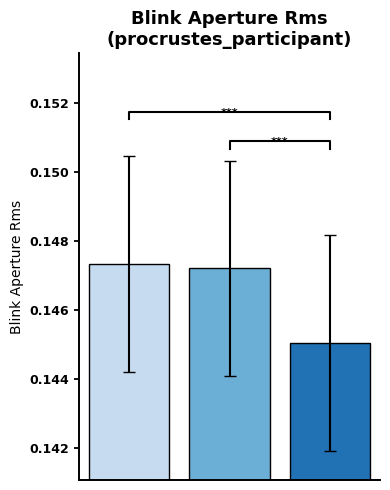

Means for mouth_aperture_mean:
  H: 0.011
  L: 0.010
  M: 0.008

=== procrustes_participant_mouth_aperture_mean (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -13195.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8140 -0.2430 -0.0669  0.1398  9.2521 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 8.779e-05 0.009370
 Residual                   7.411e-05 0.008609
Number of obs: 2014, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.707e-02  4.567e-03  4.341e+01   3.736 0.000541 ***
condition.L            7.671e-04  3.327e-04  1.966e+03   2.306 0.021215 *  
condition.Q            1.827e-03  3.320e-04  1.966e+03   5.505 4.17e-08 ***
session_or

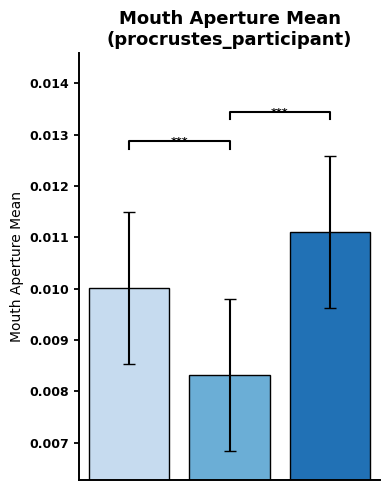

Means for mouth_aperture_rms:
  H: 0.016
  L: 0.015
  M: 0.012

=== procrustes_participant_mouth_aperture_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -12167.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4789 -0.2957 -0.0721  0.1579  7.7965 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0001687 0.01299 
 Residual                   0.0001233 0.01110 
Number of obs: 2014, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.273e-02  6.321e-03  4.335e+01   3.597 0.000821 ***
condition.L            1.388e-03  4.290e-04  1.966e+03   3.236 0.001231 ** 
condition.Q            2.554e-03  4.281e-04  1.966e+03   5.966 2.88e-09 ***
session_orde

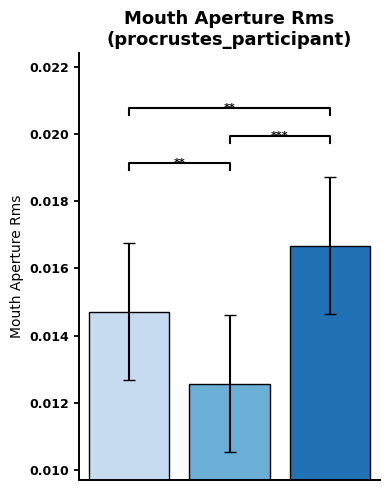

Means for pupil_dx_rms:
  H: 0.007
  L: 0.006
  M: 0.006

=== procrustes_participant_pupil_dx_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -12901.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0463 -0.0997 -0.0126  0.0567 28.7348 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 1.052e-05 0.003244
 Residual                   9.102e-05 0.009541
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)            4.997e-03  1.741e-03  4.599e+01   2.870  0.00619 **
condition.L            8.333e-04  3.682e-04  1.970e+03   2.263  0.02375 * 
condition.Q            7.042e-04  3.676e-04  1.970e+03   1.916  0.05552 . 
session_order_numeric  9.322

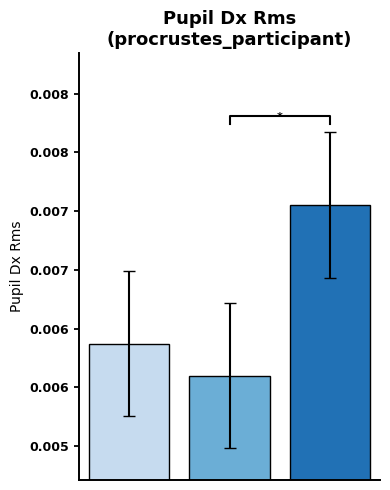

Means for pupil_dy_rms:
  H: 0.024
  L: 0.023
  M: 0.022

=== procrustes_participant_pupil_dy_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -12569.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2444 -0.1603 -0.0293  0.1167 27.1421 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.619e-05 0.005117
 Residual                   1.058e-04 0.010286
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            2.167e-02  2.601e-03  4.467e+01   8.334  1.2e-10 ***
condition.L            4.955e-04  3.970e-04  1.970e+03   1.248   0.2122    
condition.Q            9.220e-04  3.963e-04  1.970e+03   2.326   0.0201 *  
session_order_numeric  9

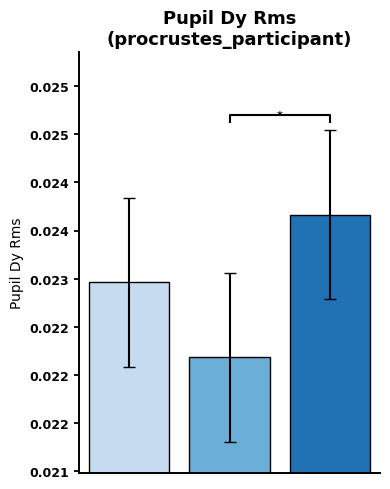

Means for pupil_metric_rms:
  H: 0.043
  L: 0.042
  M: 0.042

=== procrustes_participant_pupil_metric_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -11472.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0748 -0.1266 -0.0224  0.0904 28.3882 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 2.183e-05 0.004672
 Residual                   1.851e-04 0.013604
Number of obs: 2018, groups:  participant_id, 45

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            4.016e-02  2.503e-03  4.610e+01  16.047   <2e-16 ***
condition.L            8.801e-04  5.251e-04  1.970e+03   1.676   0.0938 .  
condition.Q            9.528e-04  5.241e-04  1.970e+03   1.818   0.0692 .  
session_order_nu

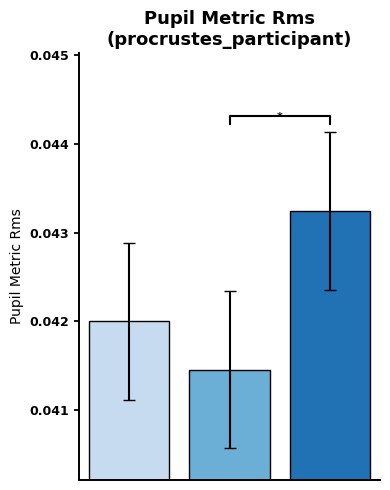


Analysis complete! Processed 33 metrics total


In [5]:
# Filter methods if user selected a subset
methods_to_analyze = pose_metrics_df["method"].unique()
results = {}

for method in methods_to_analyze:
    df_method = pose_metrics_df[pose_metrics_df["method"] == method]
    print(f"\nAnalyzing {method} normalization method...")
    results[method] = {}

    for metric in metric_cols:
        # Skip if column doesn't exist
        if metric not in df_method.columns:
            continue
        # Skip if column is all NaN
        if df_method[metric].dropna().empty:
            continue

        label = metric.replace("_", " ").title()
        pvals, means, cis = run_rpy2_lmer(df_method, metric, f"{method}_{metric}")

        if pvals is not None:
            results[method][metric] = {
                "pvals": pvals,
                "means": means,
                "cis": cis,
                "label": label
            }

            # Plots
            conds = ["L", "M", "H"]
            mean_vals = [means.get(c, float('nan')) for c in conds]
            sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]
            pval_list = [
                pvals.get(("L", "M"), 1.0),
                pvals.get(("L", "H"), 1.0),
                pvals.get(("M", "H"), 1.0)
            ]

            fig, ax = plt.subplots(figsize=(4, 5))
            barplot_ax(ax, mean_vals, sems, pval_list, ylabel=label, metric_name=metric)
            ax.set_title(f"{label}\n({method})", fontsize=13, weight='bold')
            plt.tight_layout()
            plt.show()

print(f"\nAnalysis complete! Processed {sum(len(r) for r in results.values())} metrics total")